In [ ]:
# !apt-get install pciutils

In [1]:
!nvidia-smi

Thu Nov 11 11:39:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
# !lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'

CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Socket(s):           1
NUMA node(s):        1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
NUMA node0 CPU(s):   0-3


In [60]:
# !lspci | grep VGA

00:03.0 Non-VGA unclassified device: Red Hat, Inc. Virtio SCSI


In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 사용하려는 GPU 번호
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import IPython.display as ipd
%matplotlib inline

In [3]:
SCALE = False

In [4]:
# ===DATA===
trainset = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/sample_submission.csv')

In [5]:
def split_date(df):
    '''
    args
        df: 원본 데이터프레임
    return
        year, month, day, week, weekday 정보를 추가한 dataframe
    '''
    df['year'] = pd.to_datetime(df['date_time']).dt.year
    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['day'] = pd.to_datetime(df['date_time']).dt.day
    df['week'] = pd.to_datetime(df['date_time']).dt.week
    df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
    # df['quarter'] = pd.to_datetime(df['date_time']).dt.quarter # 데이터는 모두 동일 분기 데이터이므로 무의미
    
    return df.drop(columns=['date_time'])

In [6]:
traindf = split_date(trainset)
testdf = split_date(testset)

In [7]:
keys = traindf.drop(columns=['number_of_rentals']).keys()

In [8]:
keydict = dict()
for i, k in enumerate(keys):
    keydict[i]=k

In [9]:
X = np.array(traindf.drop(columns=['number_of_rentals'])).astype(float)
y = np.array(traindf['number_of_rentals']).astype(float)
X_test = np.array(testdf).astype(float)

if SCALE:
    x_max = np.max(X, 0)
    y_max = np.max(y, 0)
    X /= x_max
    y /= y_max
    X_test /= x_max

In [10]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred)/true)

In [11]:
def cv(model, X=X, y=y, cnt=100, test_size=.5):
    score = list()
    seeds = np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *= y_max
            y_valid *= y_max
        score.append(nmae(y_valid, y_pred))
    return np.mean(score)

In [12]:
def select_features(X, cols):
    _X = list()
    for c in cols:
        _X.append(np.expand_dims(X[:, c],-1))
    return np.concatenate(_X, axis=1)

In [13]:
keydict

{0: 'wind_direction',
 1: 'sky_condition',
 2: 'precipitation_form',
 3: 'wind_speed',
 4: 'humidity',
 5: 'low_temp',
 6: 'high_temp',
 7: 'Precipitation_Probability',
 8: 'year',
 9: 'month',
 10: 'day',
 11: 'week',
 12: 'weekday'}

In [14]:
from xgboost import XGBRegressor as Model

In [16]:
min_loss = 1e10
min_cols = None

for i in np.arange(start=0, stop=len(keys)):
    model = Model(tree_method='gpu_hist', gpu_id=0)
    cols = np.arange(len(keys))
    cols = np.delete(cols, i)
    _X = select_features(X, cols)
    loss = cv(model, _X, y, cnt=30)
    if min_loss > loss:
        min_loss = loss
        min_cols = f"{keydict.get(i)}"
    print(f"{keydict.get(i)}, {loss:.4f} (min {min_loss:.4f})")

[11:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [17]:
for i in np.arange(start=0, stop=len(keys)-1):
    for j in np.arange(start=i+1, stop=len(keys)):
        model = Model(tree_method='gpu_hist', gpu_id=0)
        cols = np.arange(len(keys))
        cols = np.delete(cols, [i,j])
        _X = select_features(X, cols)
        loss = cv(model, _X, y, cnt=30)
        if min_loss > loss:
            min_loss = loss
            min_cols = f"{keydict.get(i)}, {keydict.get(j)}"
        print(f"{keydict.get(i)}, {keydict.get(j)}, {loss:.4f} (min {min_loss:.4f})")

[11:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [19]:
from matplotlib import pyplot as plt

[11:52:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


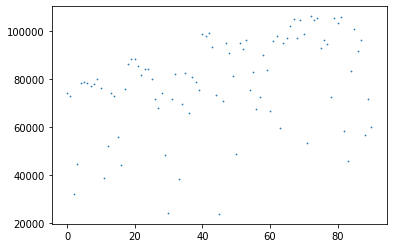

In [20]:
model = Model(tree_method='gpu_hist', gpu_id=0)

cols = np.arange(len(keys))
cols = np.delete(cols, [0,7]) # 풍향, 강수확률 제거
_X = select_features(X, cols)

model.fit(_X, y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)
if SCALE:
    y_pred *= y_max
y_pred = y_pred.astype(int)

plt.scatter(np.arange(len(y_pred)), y_pred, s=.5)
plt.show()

In [21]:
submission['number_of_rentals'] = y_pred

In [22]:
submission.to_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/xgb_test.csv', index= False)